In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
Q = 150  # m/s^3
A = 2000 # m^2
k = 400
kappa = k
R = 10000
L = 10000

pi = np.pi

a = A/pi

In [3]:
from scipy.special import jv
from scipy.special import yv
from scipy.optimize import root

### Finding eigenfunctions and -values

In [4]:
order = Q/(2*kappa*pi)
def phi_bessel(r,par):
    return (r)**(order)*jv(order, np.sqrt(par[0]/kappa)*(r)) + par[1]*(r)**(order)*yv(order, np.sqrt(par[0]/kappa)*(r))

good_roots_bessel = np.array([[3.94030436e-05,7.61848195e-01], #n=0
                              [1.71476791e-04,1.36154281e+00], #n=1
                              [3.94842613e-04,2.49685017e+00], #n=2
                              [7.08883157e-04,6.97900847e+00], #n=3
                              [1.11333787e-03,-1.12220582e+01], #n=4
                              [1.60807412e-03,-3.06309775e+00], #n=5
                              [2.19302e-03,-1.67100131e+00], #n=6
                              [2.86812e-03,-1.05017646e+00], #n=7
                              [3.63335e-03,-0.66912985e+00], #n=8
                              [4.4887e-03,-0.38862351e+00], #n=9
                              [5.43415e-03,-0.15366476e+00], #n=10
                              [6.46968e-03,0.065137e+00], #n=11
                              [7.5953e-03,0.2897497e+00], #n=12
                              [8.81099e-03,0.54445193e+00], #n=13
                              [1.011676e-02,0.86784664e+00], #n=14
                              [1.15126e-02,1.34271697e+00], #n=15
                              [1.29985e-02,2.21252377e+00], #n=16
                              [1.457447e-02,4.71344792e+00], #n=17
                              [1.62405098e-02,-2.61426615e+02], #n=18
                              [1.799661e-02,-4.44488786e+00]]) #n=20

In [5]:
N_r = 19 #len(good_roots_bessel)
N_x = 30

def phi_r_n(r,n):
    return phi_bessel(r, good_roots_bessel[n-1])

def labda_r_n(n):
    return good_roots_bessel[n-1][0]

def phi_x_n(x,n):
    return np.exp(-Q/(2*k*A)*x)*np.sin(n*pi*x/L)

def labda_x_n(n):
    return (Q/A)**2/(4*k) + k*(n*pi/L)**2

def phi_x_prime(x,n):
    return n*pi/L

def phi_r_prime(r,n):
    c = order
    w = np.sqrt(good_roots_bessel[n-1][0]/kappa)
    d = good_roots_bessel[n-1][1]
    
    T1 = d*w*r*yv(c-1, w*r)
    T2 = 2*c*d*yv(c, w*r)
    T3 = -d*w*r*yv(c+1,w*r)
    T4 = w*r*jv(c-1,w*r)
    T5 = 2*c*jv(c,w*r)
    T6 = -w*r*jv(c+1,w*r)
    return 0.5*r**(c-1)*(T1+T2+T3+T5+T6)

In [6]:
def psi(r,t):
    return (f_interp(t)-1)/(a-R)*r + (R*f_interp(t)-a)/(R-a)

def xi(x,t):
    return f_interp(t)*(1-x/L)

def ss_x(x):
    s0 = (a/R)**(2*Q/(kappa*pi))
    v = -2*Q/(A*k)
    return s0/(1-np.exp(v*L))*np.exp(v*x) + s0 - s0/(1-np.exp(v*L))


def ss_r(r):
    #return (1-(a/R)**(0.5*Q/(kappa*pi)))/(R-a)*r + 1-R*(1-(a/R)**(0.5*Q/(kappa*pi)))/(R-a)
    return (r/R)**(2*Q/(kappa*pi))

def ssn_x(x):
    s0 = (a/R)**(Q/(kappa*pi))
    v = -Q/(A*k)
    return s0/(1-np.exp(v*L))*np.exp(v*x) + s0 - s0/(1-np.exp(v*L))

def ssn_r(r):
    #return (1-(a/R)**(0.5*Q/(kappa*pi)))/(R-a)*r + 1-R*(1-(a/R)**(0.5*Q/(kappa*pi)))/(R-a)
    return (r/R)**(Q/(kappa*pi))

def u(x):
    return ss_x(x) - xi(x,0)

def v(r):
    return ss_r(r) - psi(r,0)


In [34]:
def H(r,t):
    psi_t = f_prime_interp(t)*r/(a-R) + R*f_prime_interp(t)/(R-a)
    psi_rr = 0
    psi_r = (f_interp(t)-1)/(a-R)
    return np.diag((-psi_t + kappa*psi_rr + (kappa-Q/pi)/r*psi_r)*np.ones(N_r-1))

def Lf(x,t):
    xi_t = f_prime_interp(t)*(1-x/L)
    xi_xx = 0
    xi_x = -f_interp(t)/L
    return np.diag((-xi_t + k*xi_xx + Q/A*xi_x )*np.ones(N_x-1))

def inner_x(n,m):
    return integrate.quad(lambda x: phi_x_n(x,m)*phi_x_n(x,n), 0, L)[0]

def inner_r(n,m):
    return integrate.quad(lambda r: phi_r_n(r,m)*phi_r_n(r,n), a, R)[0]

G_x = np.array([[inner_x(n,m) for n in range(1,N_x)] for m in range(1,N_x)])
G_r = np.array([[inner_r(n,m) for n in range(1,N_r)] for m in range(1,N_r)])

labda_x = np.array([labda_x_n(n) for n in range(1,N_x)])
labda_r = np.array([labda_r_n(n) for n in range(1,N_r)])
lx = np.diag(labda_x)
lr = np.diag(labda_r)
def epx_lx(t):
    return np.diag(np.exp(-t*labda_x))
def epx_lr(t):
    return np.diag(np.exp(-t*labda_r))

inv_x = np.linalg.inv(G_x)
inv_r = np.linalg.inv(G_r)


def phix(x):
    return np.array([phi_x_n(x,n) for n in range(1,N_x)])

def phir(r):
    return np.array([phi_r_n(r,n) for n in range(1,N_r)])

def phix_prime(x):
    return np.array([phi_x_prime(x,n) for n in range(1,N_x)])

def phir_prime(r):
    return np.array([phi_r_prime(r,n) for n in range(1,N_r)])

# def T_x(t):
#     I = lambda tau: integrate.quad_vec(lambda x: Lf(x,tau) @ phix, 0,L)[0]
#     func = lambda tau: exp_lx @ inv_x @ I(tau)
#     return integrate.quad_vec(func, 0,t)[0]

## Yet another attempt: Orthogonal eigenfunctions

In order to make life a little more easy, we first make the set of eigenfunctions orthogonal by using Gram-Schmidt:

In [45]:
N_r = 10

def phi_r_n(r,n):
    return phi_bessel(r, good_roots_bessel[n-1])

def phir(r):
    return np.array([phi_r_n(r,n) for n in range(1,N_r)])

M = np.diag(np.ones(N_r))
def phi_r_orth(r,n):
    res = phi_r_n(r,n)
    for i in range(n):
        res += M[n-1,i-1]*phi_r_orth(r,i)
    return res

for i in range(1,N_r-1):
    for j in range(1,i):
        vu = integrate.quad(lambda r: phi_r_n(r,i) * phi_r_orth(r,j), a, R)[0]
        rho = integrate.quad(lambda r: phi_r_orth(r,j) * phi_r_orth(r,j), a, R)[0]
        M[i-1,j-1] = -vu/rho


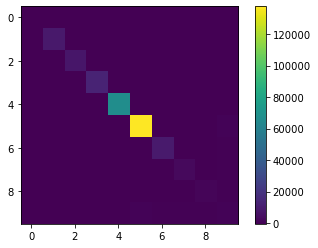

In [46]:
testm = np.zeros((N_r,N_r))
for i in range(1,N_r):
    for j in range(1,N_r):
        testm[i,j] = integrate.quad(lambda r: phi_r_orth(r,i)*phi_r_orth(r,j), a, R)[0]
        
plt.figure()
plt.imshow(testm)
plt.colorbar()
plt.show()

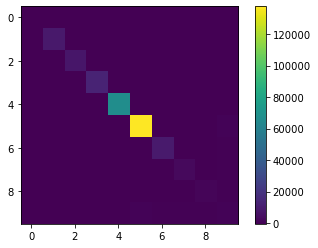

In [47]:
N_x = 10


K = np.diag(np.ones(N_x-1))
def phi_x_orth(x,n):
    res = phi_x_n(x,n)
    for i in range(n):
        res += K[n-1,i-1]*phi_x_orth(x,i)
    return res

for i in range(1,N_x):
    for j in range(1,i):
        vu = integrate.quad(lambda x: phi_x_n(x,i) * phi_x_orth(x,j), 0, L)[0]
        rho = integrate.quad(lambda x: phi_x_orth(x,j) * phi_x_orth(x,j), 0, L)[0]
        K[i-1,j-1] = -vu/rho
        
testm = np.zeros((N_r,N_r))
for i in range(1,N_r):
    for j in range(1,N_r):
        testm[i,j] = integrate.quad(lambda r: phi_r_orth(r,i)*phi_r_orth(r,j), a, R)[0]
        
plt.figure()
plt.imshow(testm)
plt.colorbar()
plt.show()


*These eigenfunctions seem to be orthogonal, so we can continue*

*Unfortunately the code runs slow because of the recursion in the definition of phi_orth and all the integrals*



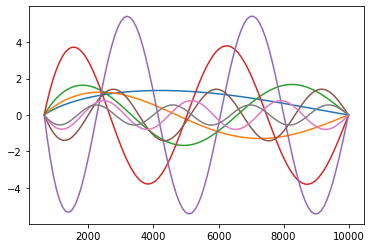

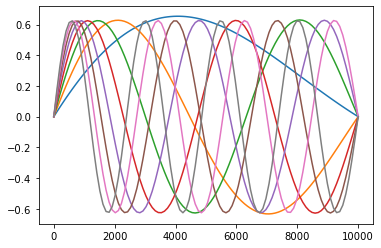

In [53]:
x = np.linspace(0,L,100)
r = np.linspace(a,R,100)

plt.figure()
for i in range(1,N_r-1):
    plt.plot(r,phi_r_orth(r,i))
plt.show()

plt.figure()
for i in range(1,N_x-1):
    plt.plot(x,phi_x_orth(x,i))
plt.show()

*These eigenfunctions look good in terms of # zero-crossings etc.*

## However, they are not really eigenfunctions anymore!

Take for example 
$$\begin{aligned} 
L(\phi) &= \lambda \phi \\
L(\psi) &= \mu \psi
\end{aligned}$$

Then $$\begin{aligned} 
L(\phi + \psi) &= \lambda \phi + \mu \psi \\
& \neq \alpha(\phi + \psi)
\end{aligned}$$

Thus, this method will not be successful. We need the eigenvalues!